<a href="https://colab.research.google.com/github/lindseyhuppin/Neur265Work/blob/main/notebooks/Place_Cells_04_03_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Discretely-Sampled Signals (Spikes - Part II)

We'll expand upon our notebook from last class by looking at the relationship between spiking and behavior.

##By the end of this notebook, you will be able to:

- Plot spiking data relative to animal behavior
- Create a model to evaluate these data
- Interpret the model's outputs
- Graph the results

##Introduction

In our last notebook, we used visualization methods and simple interspike interval models to describe the spiking properties of a retinal neuron that was maintained at constant light and environmental conditions. In other words, we examined a neuron that was firing on its own, without any explicit driving stimuli. In contrast, many neuroscience experiments involve stimulating or perturbing a neural system and recording changes in spiking activity of a set of neurons in response to that stimulus. The stimulation may be a simple signal applied directly to the neural system, such as a current pulse injected into a neuron. Or it may be a more complex or abstract stimulus that is sensed in the peripheral nervous system and influences neural activity elsewhere, such as the presentation of a movie composed of a natural scene to an awake animal, inducing activity patterns in primary visual cortex and downstream areas.

This stimulus-response paradigm relates to the important concept of neural coding: that statistical features of spiking activity contain information about the stimuli, behaviors, or other biological signals that influence the activity. From a data analysis perspective, we are interested in modeling the relation between these signals and the observed spiking activity. We can do so through a statistical spike train model. Here we explore a useful class of models based on the statistical theory of point processes. We define the models in terms of a Poisson rate function, which defines the instantaneous likelihood of observing a spike at any point in time as a function of a set of covariates. In particular, we use a class of point process models that can be fitted by maximum likelihood and whose estimators have multiple optimal properties. These are called generalized linear models (GLMs). We provide some basic statistical ideas to develop intuition about these types of models, but readers can explore the rich theory underlying this approach via the references mentioned in this notebook.

##Case study data

The spiking data we're working with today comes from a small bundle of electrodes in a rat’s hippocampus. The rat was trained to perform a simple spatial task: to run back and forth along a linear maze. During this task, we think the spiking activity from a place cell was recorded. To test this, we have the observed spike train data and the position of the rat as a function of time, recorded during a few minutes of the experiment.



<img src = 'https://drive.google.com/uc?id=1PR49YZRqLNta11NT9koVgYi8Kr3kY696'>

**Place cells** are neurons in the hippocampus (and possibly other areas of the brain) only emit action potentials when the animal occupies a specific position in space - that neuron's **place field**.

Place cells are thought to underlie our ability to form spatial memories - something for which the hippocampus is known to be critical.

##Goals

Our goal is to characterize the properties of the observed cell as the rat runs back and forth in the linear maze. Spiking activity in these cells is known to relate to other variables, such as the speed and head direction of the rat. Here, we focus on modeling the relation between the rat’s movement trajectory and the observed spiking activity. In doing so, we select a model through an iterative process of model fitting, evaluation, and refinement.



In [1]:
# Load some modules

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from statsmodels.genmod.families.links import identity, log
from scipy.stats import chi2
from statsmodels.distributions.empirical_distribution import ECDF
from pandas import DataFrame as df

><b>Task:</b> Load the <code>maze_timestamps.csv</code>, <code>maze_coordinates.csv</code>, and <code>maze_spikes.csv</code> files in as <code>numpy</code> arrays called <code>maze_timestamps</code>, <code>maze_coordinates</code>, and <code>maze_spikes</code>, respectively. The <code>maze_coordinates</code> array contains values indicating the rat's position on the linear track (in cm), the <code>maze_timestamps</code> array has timestamps for each position value (in seconds), and the <code>maze_spikes</code> array has spike timestamps recorded from a hippocampal neuron.

In [12]:
# Load your data
maze_timestamps = np.loadtxt('https://raw.githubusercontent.com/hallockh/neur_265/main/data/maze_timestamps.csv')
maze_coordinates = np.loadtxt('https://raw.githubusercontent.com/hallockh/neur_265/main/data/maze_coordinates.csv')
maze_spikes = np.loadtxt('https://raw.githubusercontent.com/hallockh/neur_265/main/data/maze_spikes.csv')

><b>Task:</b> Index the last value of your <code>maze_timestamps</code> array. Use this number to determine the frame rate (in frames per second, or fps) of the camera used to capture the rat's position data.

In [10]:
# Determine the camera's frame rate here
frame_rate = maze_timestamps.size/maze_timestamps[-1]
frame_rate

1000.0

We begin with visual inspection of the data. Let’s first plot the rat’s movement trajectory as a function of time:

><b>Task:</b> Create a plot of the rat's position on the y-axis, and time on the x-axis. Label your axes.

Text(0, 0.5, 'Location(cm)')

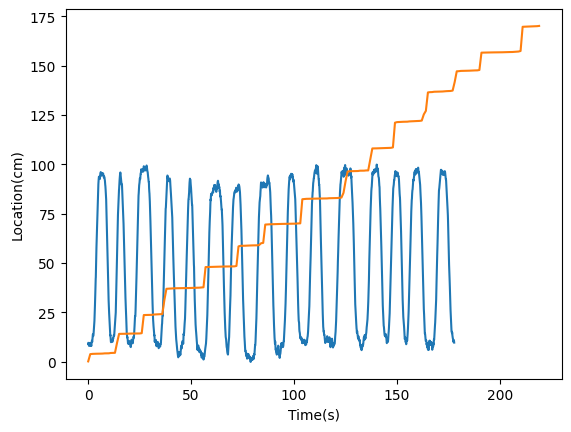

In [19]:
# Make your plot!
plt.plot(maze_timestamps,maze_coordinates)
plt.plot(maze_spikes)
plt.xlabel('Time(s)')
plt.ylabel('Location(cm)')

The plot shows that the rat runs back and forth consistently, making about 15 passes during the approximately 3 minute recording. We also observe that the rat moves fairly quickly during each back and forth pass but spends a large amount of time at both ends of the track (near position 0 cm or 100 cm) before turning around and continuing.

Next, we would like to plot the spiking activity in relation to the rat’s movement trajectory. However, we cannot simply plot the vector `maze_coordinates` against the vector `maze_spikes`; these vectors have different lengths. The length of `maze_coordinates` is the same as the length of `maze_timestamps`, the total number of 1 ms time bins in the recording (177,761 time bins). The length of `maze_spikes` is the total number of spikes to occur during the duration of the recording: 220 spikes. Therefore, the first step to visualizing the place-specific spiking activity is to use `maze_spikes` to create a new vector, with the same size as `maze_coordinates`, that indicates whether a spike was fired at each time bin. Let’s call this vector `spiketrain` and have it contain 1 for each time bin where a spike occurs and 0 for each time bin that lacks a spike.

In [20]:
n_bins = len(maze_timestamps)
# Histogram spikes into bins centered at times t:
spiketrain = np.histogram(maze_spikes,
                         bins = n_bins,
                         range = (maze_timestamps[0], maze_timestamps[-1]))[0]

Now we can plot the position and spike train together.

Text(0, 0.5, 'Position [cm]')

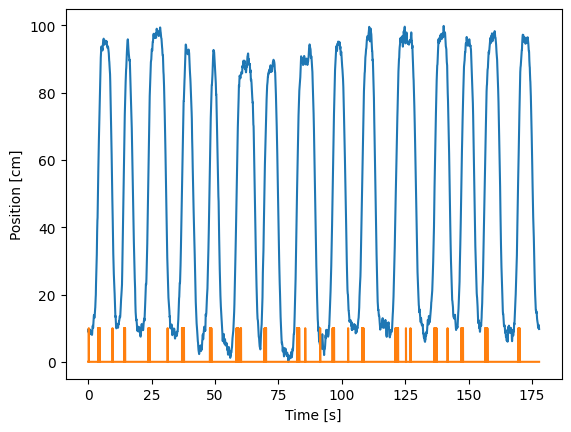

In [21]:
plt.plot(maze_timestamps, maze_coordinates)               # Plot the position,
plt.plot(maze_timestamps, 10 * spiketrain) # Plot the spikes,
plt.xlabel('Time [s]')   # ... and label the axes.
plt.ylabel('Position [cm]')

Is there a better way to visualize the spiking activity and position? Keeping the variable `spiketrain`, let’s compute a new variable, `spikeindex`, using the `numpy` command `where()`. The vector `spikeindex` represents the vector indices at which spikes occur. We can use this to index any of the variables whose size matches the number of time bins in the recording. So, another visualization we can now employ is to plot the times and positions of the spikes overlaid on the full movement trajectory.

Text(0, 0.5, 'Position [cm]')

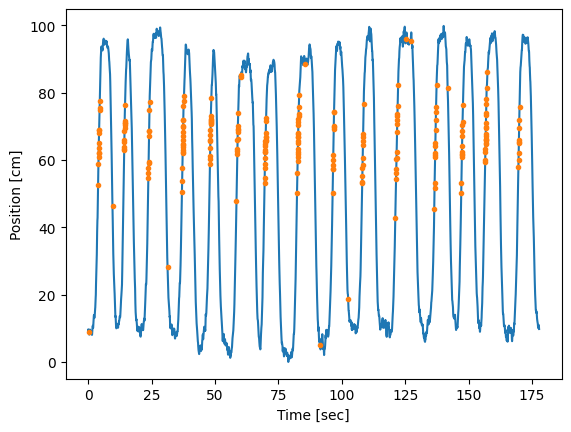

In [22]:
spikeindex = np.where(spiketrain!=0)[0]     # Get the spike indices.
plt.plot(maze_timestamps, maze_coordinates)                               # Plot the position,
plt.plot(maze_timestamps[spikeindex], maze_coordinates[spikeindex], '.')  # ... and the spikes.
plt.xlabel('Time [sec]')                     # Label the axes.
plt.ylabel('Position [cm]')

Question: What do you notice about the firing pattern from this cell? Does it fire at a specific position along the linear track? At specific timepoints?

Fires between 60 and 80 cm.

Another way to visualize this place field structure is to construct an occupancy normalized histogram of the spiking activity. To do so, we define a set of position bins spanning the full 100 cm track, count the number of spikes that occur in each location bin, and divide by the occupancy, the total amount of time spent at each location bin. Dividing by the occupancy is important. Otherwise differences in the way the stimulus is presented can bias the characterization of the stimulus response relation. For example, if the rat spent much more time in the 50–80 cm region, we might expect more firing in that region even if the firing does not depend on place at all. Based on our previous visualization, we know that this is not the case for these data, but it is important to keep in mind how the statistics of a stimulus signal might influence the statistics of an output signal.

Text(0, 0.5, 'Occupancy norm. hist. [spikes/s]')

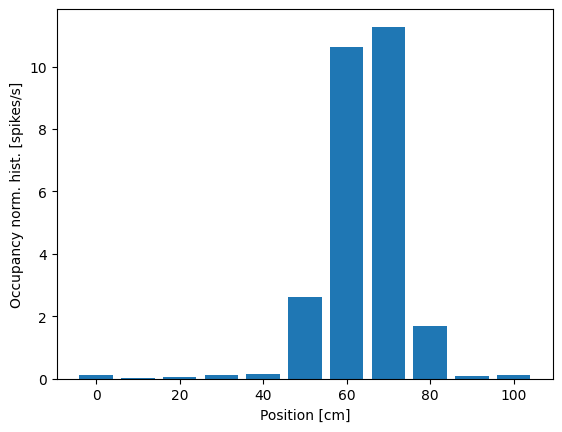

In [25]:
bin_edges = np.arange(-5, 106, 10)                              # Define spatial bins.
spikehist = np.histogram(maze_coordinates[spikeindex], bin_edges)[0]           # Histogram positions @ spikes.
occupancy = np.histogram(maze_coordinates, bin_edges)[0]*0.001                 # Convert occupancy to seconds.
plt.bar(np.linspace(0, 100, 11), spikehist/occupancy, width=8)  # Plot results as bars.
plt.xlabel('Position [cm]')                                      # Label the axes.
plt.ylabel('Occupancy norm. hist. [spikes/s]')

In the third line of this code, we multiply the occupancy by 0.001 to put the occupancy in units of seconds and the occupancy normalized histogram in units of spikes per second. From the occupancy normalized histogram in the figure, we see that the firing rate is highest around the 60–70 cm position and falls off rapidly as the rat moves away from that location. This corroborates the results from our previous visualizations. However, there is one feature of the spiking activity that we observed previously for which we are not accounting in this visualization. Here we are relating spiking purely to position without regard for the direction of the rat’s movement.

##Fitting a Point Process Model (Poisson GLM)

Any statistical model that describes data occurring at localized points in time, like spike times, is called a temporal point process model. Here, we would like to construct a statistical model, but in this case the model should characterize how the distribution of the data depends on the covariates of interest: the rat’s position and movement direction.

GLM = regression but can modify things so it doesn't have to be linear

One approach we use to model spiking data is a Poisson model, in which we use a rate parameter, 𝜆
, to define the expected rate of spiking in any time interval. We then compute the value of 𝜆
 that maximizes the likelihood of observing the recorded spiking activity. For the data of interest here, we extend this concept by defining a rate that varies in time as a function of some set of covariates. These covariates are any variables whose influence on the spiking activity we wish to explore. Our visualizations suggest that useful covariates for our model include the rat’s position and its direction of motion.

Let’s define some terms. Let 𝑥(𝑡)
 represent the rat’s position at time 𝑡
, and let 𝑑(𝑡)
 represent the direction of motion; we set 𝑑(𝑡)=0
 when 𝑥(𝑡)
 is decreasing or the rat is stopped, and 𝑑(𝑡)=1
 when 𝑥(𝑡)
 is increasing. Since these position and direction signals change as a function of time, so does the firing rate. We write 𝜆(𝑡)=𝑔(𝑥(𝑡),𝑑(𝑡))
, where 𝜆(𝑡)
 is called the Poisson rate function, and 𝑔(·,·)
 is a function that we need to define the model.

What function should we use for 𝑔(·,·)
? We want something that captures the relation between the covariates and the spiking, and is easy to interpret. The process of finding a model or set of models that are most consistent with the data is called model identification or model selection. Typically, this is an iterative process where we propose a class of models, find the particular model in that class that best fits the data, assess the quality of that model, and decide whether to refine the model further or to draw conclusions from the model fit. In practice, it is a good idea to begin with descriptive statistics and visualizations of the relation between the covariates and spiking data to select a class of point process models. For the spike train data of interest here, our visualizations suggest a model where the dependence of spiking on position has a mound shape (as in the occupancy normalized histogram) and which incorporates direction. We start with an overly simple model for pedagogical purposes.

The following is a very basic model inspired by simple linear regression:

𝜆(𝑡)=𝛽0+𝛽1𝑥(𝑡).

The idea of linear regression is to express a response variable at time 𝑡
 in terms of predictor variables, or covariates. Here, 𝛽0
 and 𝛽1
 are unknown parameters used to characterize a linear dependence between the response variable 𝜆(𝑡)
 and covariate 𝑥(𝑡)
. 𝛽0
 represents the expected firing rate at 𝑥(𝑡)=0
, and 𝛽1
 represents the change in firing rate for each unit of increase in position. This initial model does not include any dependence on the rat’s movement direction (i.e., there’s no 𝑑(𝑡)
 term).

The form of the model looks like a standard linear regression, which is comforting because methods exist in Python to solve these types of problems. However, the observed data are spike events; in discrete time, the data are spike counts. A standard linear regression assumes that the distribution of the data, given the covariates, is normal. Spike counts can take on only non-negative integer values, so their distribution cannot be normal. When the number of spike counts in each time bin is very large, it is possible that the distribution of the data can be approximated by a normal distribution, and in this case, simple regression methods might work. But for the spiking data of interest here, we have very few spikes (0 or 1) in each 1 ms time bin, so a simple regression fit would not be correct.

Instead, we must fit a Poisson regression model to the data. How do we fit the Poisson regression model? It turns out that Poisson regression models of a certain form can be fitted efficiently using the theory of generalized linear models. In Python, we can fit this model using the `statsmodel` package.

In [26]:
# Create a dataframe of predictors that includes X and a constant term
predictors = df(data={'Intercept': np.ones_like(maze_coordinates), 'X': maze_coordinates})

# GLM model with Poisson family and identity link function
model1 = sm.GLM(spiketrain, predictors, family=Poisson(identity()))
model1_results = model1.fit() # Fit model to our data
b1 = model1_results.params
print('b1:')
print(b1)

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


b1:
Intercept   -0.000097
X            0.000027
dtype: float64


Let's plot again our occupancy-normalized histogram of spikes across positions, and plot over top of it the model's predicted firing rate across positions:

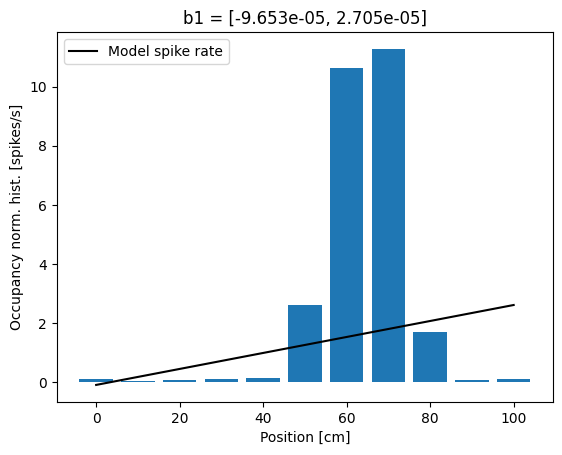

In [27]:
bins = np.linspace(0, 100, 11)
plt.bar(bins, spikehist/occupancy, width=8)    # Plot results as bars.
plt.plot(bins,(b1[0]+b1[1]*bins)*1000, 'k',
     label="Model spike rate")             # Plot model.
plt.xlabel('Position [cm]')                    # Label the axes.
plt.ylabel('Occupancy norm. hist. [spikes/s]')
plt.title("b1 = [{0[0]:.4}, {0[1]:.4}]".format(b1))
plt.legend()

Question: Does the model seem like a good fit for the data? Why or why not?

No it's not a good fit. It goes up but other than that it doesn't fit.

##Refining the Model

We conclude that our initial proposal, Model 1, does not represent the data well. Therefore, let’s refine the model to account for the identified issues. First, let’s choose a link function that is more appropriate for point process modeling. We would like a function that ensures the rate function is non-negative and that is easy to fit. The theory of generalized linear modeling suggests one function in particular: the log link. We set the log of the firing rate to be a linear function of the covariates. If we maintain position as the sole covariate, this leads to a model of the form:

log𝜆(𝑡)=𝛽0+𝛽1𝑥(𝑡),

or equivalently,

𝜆=𝑒𝛽0+𝛽1𝑥(𝑡).

This link function is called the canonical link for Poisson data. It has a number of appealing properties. As desired, it ensures that the rate function is positive.

To fit Model 2 in Python, we use the same model as before but replace the the link function with log:

In [28]:
model2 = sm.GLM(spiketrain, predictors, family=Poisson(log())) # GLM model with Poisson family and log link function
model2_results = model2.fit() # Fit model to our data
b2 = model2_results.params    # Get the predicted coefficient vector

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Let's plot the results from Model 2 on top of our histogram, and see if we get a better result:

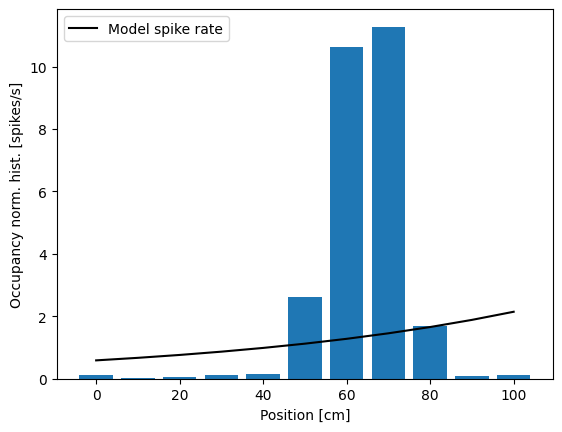

In [29]:
plt.bar(bins, spikehist/occupancy, width=8)    # Plot results as bars.
plt.plot(bins, np.exp(b2[0] + b2[1] * bins) * 1000, 'k',
     label='Model spike rate')             # Plot model.
plt.xlabel('Position [cm]')                    # Label the axes.
plt.ylabel('Occupancy norm. hist. [spikes/s]')
plt.legend()

Question: How do the two models compare? Is Model 2 a better fit? Why?

Maybe better, but still not good. All positive values, but doesn't increase as much. It doesn't really fit any better.

There are many variables we might think to add to this model, but what variables could we add to better capture the dependence between firing rate and position, in particular? One thought might be to include nonlinear terms, such as the square of the position value. This gives us a third candidate model:

𝜆(𝑡)=exp(𝛽0+𝛽1𝑥(𝑡)+𝛽2𝑥(𝑡)2).

To fit Model 3 in Python, we add another column to the matrix of covariates, the second argument of the GLM model.

In [30]:
# Fit Model 3 to the spike train data (omitting last input).
predictors['X2'] = maze_coordinates**2       # Add column for X^2

# GLM model with Poisson family and identity link function
model3 = sm.GLM(spiketrain, predictors, family=Poisson())
model3_results = model3.fit() # Fit model to our data
b3 = model3_results.params    # Get the predicted coefficient vector
print('b3:\n', b3)

b3:
 Intercept   -26.279057
X             0.690114
X2           -0.005463
dtype: float64


Let's plot our results from Model 3!

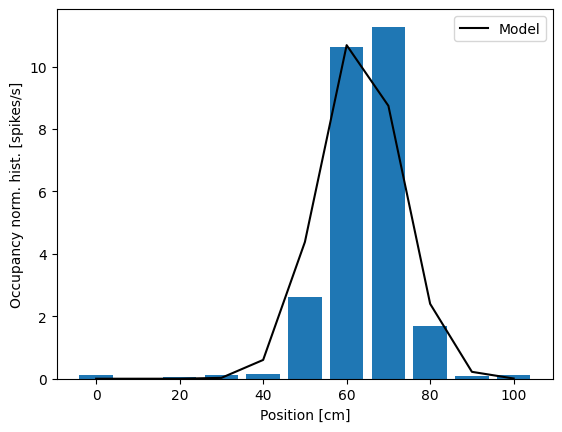

In [31]:
plt.bar(bins, spikehist / occupancy, width=8)    # Plot results as bars.
plt.plot(bins, np.exp(b3[0] + b3[1] * bins + b3[2] * bins**2) * 1000,  # Plot model.
     'k', label='Model')
plt.xlabel('Position [cm]')                      # Label the axes.
plt.ylabel('Occupancy norm. hist. [spikes/s]')
plt.legend()

Question: How did this model do?

Better than the other two. Fits the bars.

We can now use our model results to predict the position of this neuron's place field, how big the place field is, and the neuron's maximum firing rate within its place field:

In [32]:
#Compute maximum likelihood estimates of
mu = -b3[1] / (2 * b3[2])                  # place field center
sigma = np.sqrt(-1 / (2 * b3[2]))             # place field size
alpha = np.exp(b3[0] - b3[1]**2 / 4 / b3[2])  # max firing rate

print('mu: {}\nsigma: {}\nalpha: {}'.format(mu, sigma, alpha))

mu: 63.16295780420328
sigma: 9.566890841729677
alpha: 0.011285495199383518


mu = average
sigma = standard deviation
alpha = spikes about 11 Hz

We see that the estimated place field center is about 63.2 cm down the track. The estimated place field size, 𝜎̂ =9.6
, suggests that the firing rate decreases about 40% when the rat is about 9.6 cm from the place field center, and decreases about 85% when the rat is about 19 cm from the place field center. The neuron spikes at a rate near 𝛼̂ =11
 spikes/s when the rat is 63 cm along the track, but less than 2 spikes/s when the rat is more than 19 cm away from that position.

##Comparing and Evaluating Models

We have fit a number of models for the receptive field of this neuron and compared these models through visual inspection. Ideally, we’d like to go beyond qualitative comparisons and consider quantitative tools to help us evaluate and compare different models. For statistical models, we often use the term goodness-of-fit to describe how well a model captures structure in the observed data, and how well the model predicts future data. There is not a single procedure for measuring goodness-of-fit; instead there are many tools that, taken together, can provide a broad perspective on the strengths and weaknesses of a set of models.

##Chi-Square Test for Nested Models

In order to assess whether a model provides a significant improvement over another, we can use hypothesis tests based on the model likelihoods.

In particular, there is a general class of hypothesis tests called maximum likelihood ratio tests (MLRTs) that often provide the most statistically powerful comparison between models. In general, it can be challenging to compute the test statistic and its sampling distribution for MLRTs. However, it becomes easy to perform this test in cases where we are comparing two nested GLMs, that is, when one of the models can be made equivalent to the other by setting some parameters to specific values. For example, it is possible to make Model 3 equivalent to Model 2 by setting 𝛽2=0
. We say that Model 2 is nested in Model 3. However, there is no way to set any parameters to make Model 2 equivalent to Model 1 or vice versa, so these models are not nested. It can be shown that when we compare two nested Poisson GLMs for spike train data, the MLRT will asymptotically be a simple chi-square (𝜒2
) test.

In [35]:
dev2 = model2_results.deviance # Deviance from model 2
dev3 = model2_results.deviance # Deviance from model 3
p = 1 - chi2.cdf(dev2 - dev3, 1) # Compare Models 2 and 3, nested GLMs.
print('p:', p)
#p=0 shows model 3 does a much better job than model 2

p: 1.0


We find the computed p-value is zero, to the precision that Python is able to compute the chi-square distribution. In practice, this means that the p-value for this test is not exactly zero but is smaller than approximately 2^−16

##Residual Analysis

Residuals represent the difference between the data and the model prediction at the level of individual data points. Residual analysis is essential for understanding which components of a dataset are well or ill fit by the model. It is therefore one of the best tools for determining what is missing in a model.

Residual is distance between point and the line of best fit for each point.

In Python, we compute the residual process by taking the cumulative sum of the raw residuals, which are returned as an attribute of the `GLMResults` class. Then, to compute the cumulative sum of these residuals, we use the function `cumsum()` as follows:

In [40]:
R = np.cumsum(model3_results.resid_response)

To inspect how the cumulative residual process evolves in time, let’s plot it:

Text(0, 0.5, 'Cumulative Residuals')

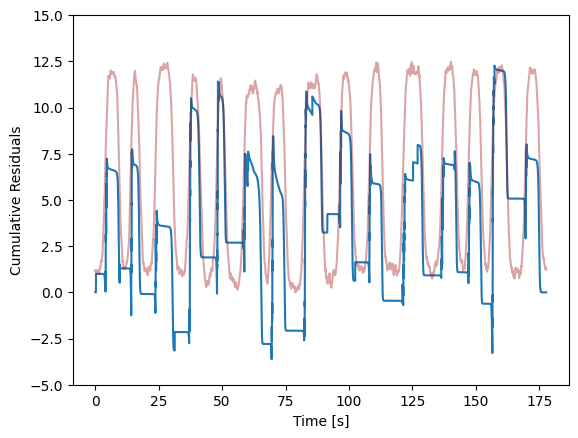

In [49]:
plt.plot(maze_timestamps, R)
plt.plot(maze_timestamps,maze_coordinates/8,'#9f0a0a5d')
plt.ylim(-5, 15)
plt.xlabel('Time [s]')
plt.ylabel('Cumulative Residuals')

If Model 3 were correct, then the residuals should be zero mean and uncorrelated with any covariates. We see in the figure above that the cumulative residual process ends at zero, suggesting that the residuals sum to zero over all time steps. However, we also identify a pattern in the residual process, which suggests that there is still some structure in the data that is not captured by Model 3. More specifically, visual inspection suggests a relation between the residuals and a model covariate: the position (see figure generated by the code below). We observe that the cumulative residual process seems to increase whenever the rat in moving in the positive direction and to decrease whenever the rat is moving in the negative direction. This analysis suggests exactly what has been missing from our models: direction.

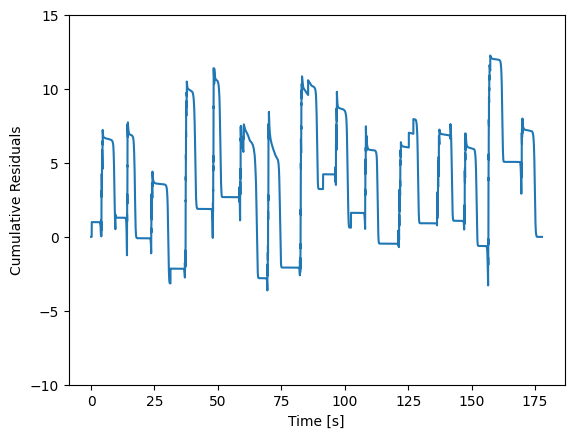

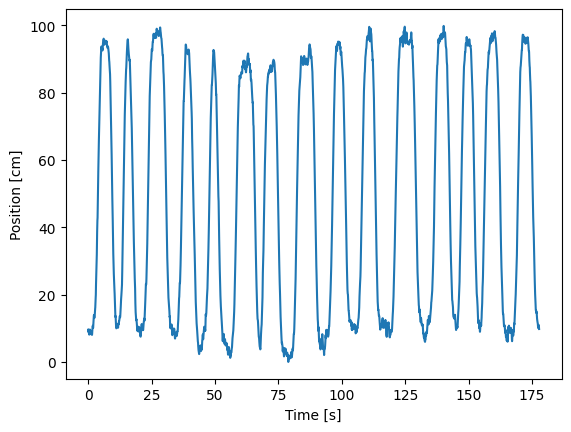

In [50]:
# Comparison of Cumulative residuals over time and rat position over time.
plt.plot(maze_timestamps, R)
plt.ylim(-10, 15)
plt.xlabel('Time [s]')
plt.ylabel('Cumulative Residuals')
plt.show()
plt.plot(maze_timestamps, maze_coordinates)
plt.xlabel('Time [s]')
plt.ylabel('Position [cm]')
plt.show()

##Refining the Model (Continued)

Our goodness-of-fit analysis suggested that Model 3 provided a significant improvement over Model 2. However, analysis of the cumulative residual process revealed that Model 3 misses an essential feature of the data: Model 3 does not account for the dependence of spiking on direction. So, let’s refine the model by including a new covariate that captures the direction of the rat’s movement.

We must first define a simple indicator function for the direction of movement. If the value of 𝑋(𝑡)
 increased since the last time step, we set this variable to 1; otherwise we set it to 0. For the very first time step, we don’t know from which direction the rat came, so we set it to 0 arbitrarily.

In [54]:
increasing = np.where(np.diff(maze_coordinates.flatten()) > 0)[0]  # Array for if X(t) increased since last step
direction = np.zeros_like(maze_coordinates)  # Create a direction array the same size as X
direction[increasing] = 1  # Set direction to 1 when X is increasing

With the indicator function for the direction of movement now defined, we must incorporate this new signal into the model. The simplest solution is to add the direction variable directly as a new predictor. This would lead to a new model,

𝜆(𝑡)=exp(𝛽0+𝛽1𝑥(𝑡)+𝛽2𝑥(𝑡)2+𝛽3direction.

In [55]:
#Fit Model 4, and return estimates and useful statistics.
predictors['direction'] = direction #Add column for direction
# GLM model with Poisson family and default (log) link function
model4 = sm.GLM(spiketrain, predictors, family=Poisson())
model4_results = model4.fit()       # Fit model to our data
b4 = model4_results.params          # Get the predicted coefficient vector
print(b4)

Intercept   -28.870275
X             0.688905
X2           -0.005452
direction     3.275282
dtype: float64


To evaluate the significance, we can once again perform an MLRT. Model 3 is clearly nested in Model 4, since under the null hypothesis that 𝛽3=0
, we obtain Model 3. Because there is only one parameter to fix, the MLRT statistic would have a chi-square distribution with 1 degree of freedom if the null hypothesis were true. So we compute the p-value for this test as

In [56]:
dev4 = model4_results.deviance
p = 1 - chi2.cdf(dev3 - dev4, 1)  # Compare Models 3 and 4, nested GLMs.
print(p)

0.0


and find 𝑝=0
. Again, we see that the addition of a parameter leads to a highly significant improvement in the fit to the data.

Finally let’s compute and examine the cumulative residual process:

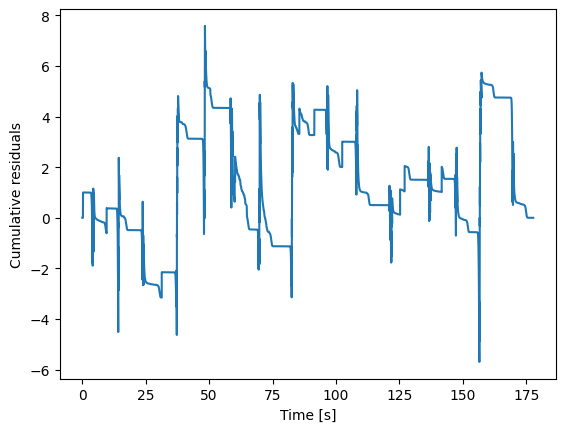

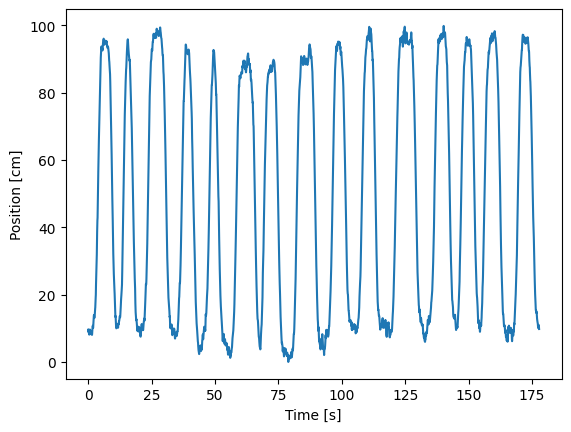

In [60]:
R = np.cumsum(model4_results.resid_response)  # Cumulative sum of Model 4 residuals.
plt.plot(maze_timestamps, R)                                  # Plot it.
plt.xlabel('Time [s]')
plt.ylabel('Cumulative residuals')
plt.show()

plt.plot(maze_timestamps, maze_coordinates)
plt.xlabel('Time [s]')
plt.ylabel('Position [cm]')
plt.show()

The figure above plots the cumulative residual process for Model 4 and the movement trajectory. We find that the residual process is now centered at zero. There may still be some structure as a function of time, but it is no longer as closely associated with the movement trajectory as for Model 3.

It is likely that we could refine this model further, perhaps by adding additional covariates or including different dependence structure on the covariates we are currently using. The process of model refinement is not about identifying a single correct model. Instead, it is about building a model that sufficiently captures features of the data in which we are interested. For this analysis, let’s decide that based on our multiple goodness-of-fit tools, Model 4 is good enough. We now use this model to better understand the structure of the place cell that generated these data.

The process of model refinement and comparison has helped us identify important features of this neuron’s receptive field. It was clear from the initial visualizations that this neuron’s firing activity is position sensitive; it is more likely to fire when the animal is at certain positions than others. Our modeling analysis further showed that this position dependence could be well described by an exponentiated quadratic function of position, that is, a Gaussian-shaped function.

Let’s now estimate parameters for the center, width, and maximum firing rate of this place field. To do so, we make use of the expressions derived for the alternative form of Model 3. Computing these values for the estimates of Model 4 (variable b4),

In [62]:
#For Model 4, compute maximum likelihood estimates of
mu = -b4[1] / (2 * b4[2])                 # place field center
sigma = np.sqrt(-1 / (2 * b4[2]))            # place field size
alpha = np.exp(b4[0] - b4[1]**2 / (4 * b4[2]))  # max firing rate

print('mu: ', mu)
print('sigma: ', sigma)
print('alpha: ', alpha) #firing rate

mu:  63.18440082996137
sigma:  9.576905113644994
alpha:  0.0008199709289060013


The place field is centered approximately 63 cm down the track (mu = 63.18), and most of the firing activity occurs in a region between about 63±19
 cm (sigma = 9.58, so 2 * sigma = 19.16). At first, the maximum firing rate value of about alpha = 8.2e-4 spikes/ms, or 0.8 spikes/s seems too small, until we realize that this is the maximum firing rate only when dir=0. When dir=1, this is multiplied by 𝑒𝛽3=
 exp(b4[3])=26.451. The maximum firing rate when the rat moves in the positive direction is about 26 spikes/s.

Let’s also visualize the firing rate as a function of both position and direction. We use the `predict` function to do this. This function uses both the parameter estimates and the `stats` structure that is output by `fit`, and computes the estimated Poisson rate function.

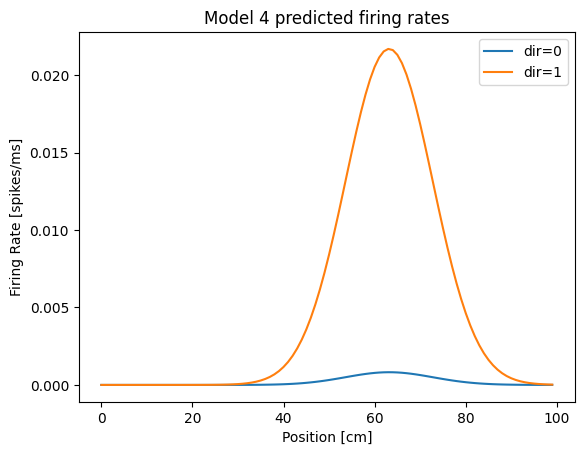

In [63]:
xs = np.arange(100)

# Create an array with [constant, position, position squared, direction] terms
dir_0 = np.array([np.ones_like(xs), xs, xs**2, np.zeros_like(xs)]).T  # ... for when the direction is 0
dir_1 = np.array([np.ones_like(xs), xs, xs**2, np.ones_like(xs)]).T  # ... and for when direction is 1
lambda4_0 = model4_results.predict(dir_0)  # Predict the firing rate when the direction is 0
lambda4_1 = model4_results.predict(dir_1)  # ... and when the direction is one

plt.plot(xs, lambda4_0, label="dir=0")  # Plot results
plt.plot(xs, lambda4_1, label="dir=1")
plt.xlabel('Position [cm]')
plt.ylabel('Firing Rate [spikes/ms]')
plt.title('Model 4 predicted firing rates')
plt.legend()